In [1]:
%matplotlib inline
from netCDF4 import Dataset
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import requests
import netCDF4
import boto3
import pprint
import gc
import threading
import pickle
from pathlib import Path

# About the Data:

All data files from GOES-16 (formerly GOES-R) are provided in netCDF4 format. The GOES-16 data is hosted in the noaa-goes16 Amazon S3 bucket in the us-east-1 AWS region. Individual files are availabe in the netCDF format with the following schema:

### < Product>/< Year>/< Day of Year>/< Hour>/< Filename>

where:

- < Product> is the product generated from one of the sensors aboard the satellite (e.g.)
        ABI-L1b-RadF
        ABI-L1b-RadC
        ABI-L1b-RadM
- < Year> is the year the netCDF4 file was created
- < Day of Year> is the numerical day of the year (1-365)
- < Hour> is the hour the data observation was made
- < Filename> is the name of the file containing the data. These are compressed and encapsulated using the netCDF4 standard.

A < Filename> is delineated by underscores ‘_’ and looks like this:

### OR_ABI-L1b-RadF-M3C02_G16_s20171671145342_e20171671156109_c20171671156144.nc

where:

- OR: Operational system real-time data
- ABI-L1b-RadF-M3C02 is delineated by hyphen ‘-’:
        ABI: is ABI Sensor
        L1b: is processing level, L1b data or L2
        Rad: is radiances. Other products include CMIP (Cloud and Moisture Imagery products) and MCMIP (multichannel CMIP).
        F: is full disk (normally every 15 minutes), C is continental U.S. (normally every 5 minutes), M1 and M2 is Mesoscale region 1 and region 2 (usually every minute each)
        M3: is mode 3 (scan operation), M4 is mode 4 (only full disk scans every five minutes – no mesoscale or CONUS)
        C02: is channel or band 02, There will be sixteen bands, 01-16
- G16: is satellite id for GOES-16 (future G17)
- s20171671145342: is start of scan time
        4 digit year
        3 digit day of year
        2 digit hour
        2 digit minute
        2 digit second
        1 digit tenth of second
- e20171671156109: is end of scan time
- c20171671156144: is netCDF4 file creation time
- .nc is netCDF file extension

In [2]:
#Path.cwd finds the "current working directory"
this_dir=Path.cwd()
data_dir = this_dir / Path('GOES data files')
all_data=list(data_dir.glob("*.nc"))
netcdf4_files=[str(i).split('\\')[-1] for i in all_data]

## If set to true, this will download data files using rclone to the data directory

In [3]:
pp = pprint.PrettyPrinter(depth=8)
pp.pprint(netcdf4_files)

['OR_ABI-L1b-RadF-M6C01_G17_s20191542000341_e20191542009408_c20191542009438.nc',
 'OR_ABI-L1b-RadF-M6C02_G17_s20191542000341_e20191542009408_c20191542009437.nc',
 'OR_ABI-L1b-RadF-M6C03_G17_s20191542000341_e20191542009408_c20191542009440.nc']


## Retrieve the first measurement of the hour for bands 1,2 and 3. These are the Blue, Red and Veggie (NIR) bands respectively

In [4]:
bands = ['01','02','03']
year = 2019
doy = 154
hour = 20
mins= 0
start_scan = str(year)+str(doy).zfill(3)+str(hour).zfill(2)+str(mins).zfill(2)
start_scan


files=[]
for x in netcdf4_files:   
    if (start_scan in x) and ((x[44:46]) in bands):
        files.append(x)
files

['OR_ABI-L1b-RadF-M6C01_G17_s20191542000341_e20191542009408_c20191542009438.nc',
 'OR_ABI-L1b-RadF-M6C02_G17_s20191542000341_e20191542009408_c20191542009437.nc',
 'OR_ABI-L1b-RadF-M6C03_G17_s20191542000341_e20191542009408_c20191542009440.nc']

## Band descriptions:


- Band 1: Blue (0.47 $\mu m$)
- Band 2: Red (0.64 $\mu m$)
- Band 3: Veggie (Near IR) (0.86 $\mu m$)

## Generate Green band from general first order linear approximation of:

 0.48358168 * red + 0.45706946 * blue + 0.06038137 * veggie
 

 
## Create true colour
- For natural color, we first want to convert radiances to reflectance.

### Calculate Reflectance

$reflectance$=$\frac{\pi d^2 radiance}{Esun}$
    
    
  
## Gamma Correction
- The reflectance may make the images too dark. This is because the values are in linear units. A simple gamma correction to adjusts this and brightens the image.

$corrected \space\space reflectance$=$\sqrt{old \space\space reflectance}$
    

- Combine the new output (R, G, B) to make a natural or enhanced RGB image.


In [5]:
#Default constants 
d2 = 0.3
file_name= (files[0][0:41])

In [6]:
# Apply the formula to convert radiance to reflectance
def calc_reflectance(rad,kappa):
    """
    formula to convert radiance to gamma corrected reflectance
    """
    
#     ref = (rad * np.pi * d2) / esun
    ref = rad*kappa
    # Make sure all data is in the valid data range
    ref = np.maximum(ref, 0.0)
    ref = np.minimum(ref, 1.0)
    gamma_ref = np.sqrt(ref)
    return gamma_ref

## Download Band 1 (Blue)

In [7]:
channel_1 = str(data_dir)+'\\'+files[0]
g16nc = Dataset(channel_1, 'r')
esun_1=(g16nc.variables['esun'][0])
radiance_1 = g16nc.variables['Rad'][::4,::4]
kappa_1=(g16nc.variables['kappa0'][0])
g16nc.close()
g16nc = None

In [8]:
ref_gamma_1 = calc_reflectance(radiance_1,kappa_1)

In [32]:
radiance_1.data

array([[1023., 1023., 1023., ..., 1023., 1023., 1023.],
       [1023., 1023., 1023., ..., 1023., 1023., 1023.],
       [1023., 1023., 1023., ..., 1023., 1023., 1023.],
       ...,
       [1023., 1023., 1023., ..., 1023., 1023., 1023.],
       [1023., 1023., 1023., ..., 1023., 1023., 1023.],
       [1023., 1023., 1023., ..., 1023., 1023., 1023.]], dtype=float32)

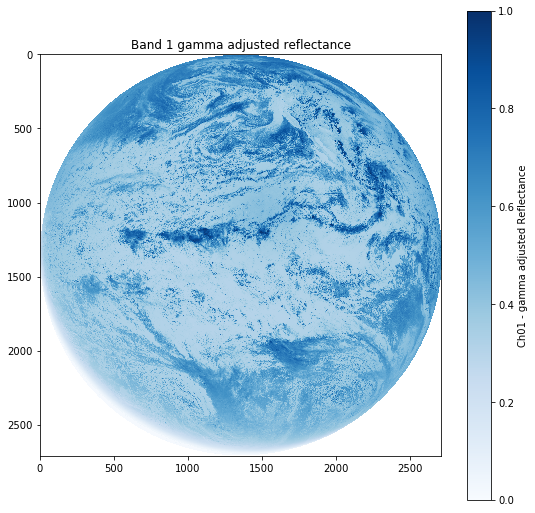

In [19]:
#Plot gamma adjusted reflectance channel 1
image_name= "Band 1 gamma adjusted reflectance " + file_name + ".png"

fig = plt.figure(figsize=(9,9))
im = plt.imshow(ref_gamma_1, cmap='Blues')
plt.title('Band 1 gamma adjusted reflectance')
cb = fig.colorbar(im, orientation='vertical')
cb.set_ticks([0, 0.2, 0.4, 0.6, 0.8, 1.0])
cb.set_label('Ch01 - gamma adjusted Reflectance')
plt.show()

image_name= "Band 1 gamma adjusted reflectance " + file_name + ".png"
# plt.savefig(image_name, dpi=300, facecolor='w', edgecolor='w')

## Download Band 2 (Red)

In [10]:
channel_2 = str(data_dir)+'\\'+files[1]
g16nc = Dataset(channel_2, 'r')
esun_2=(g16nc.variables['esun'][0])
radiance_2 = g16nc.variables['Rad'][::4,::4]
kappa_2=(g16nc.variables['kappa0'][0])
g16nc.close()
g16nc = None

In [11]:
ref_gamma = calc_reflectance(radiance_2,kappa_2)

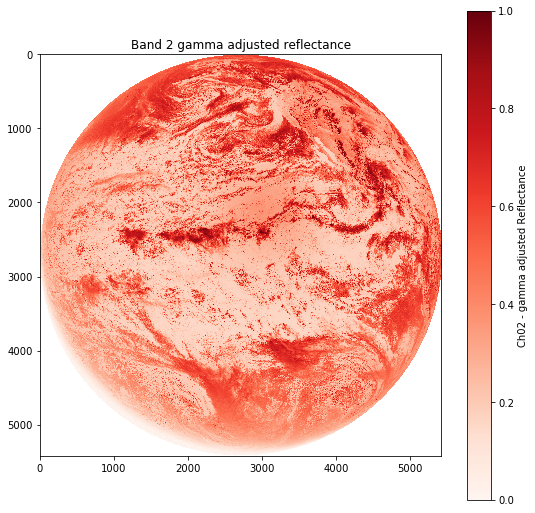

In [21]:
# Plot reflectance
image_name= "Band 2 gamma adjusted reflectance " + file_name + ".png"
fig = plt.figure(figsize=(9,9))
im = plt.imshow(ref_gamma, cmap='Reds')
plt.title('Band 2 gamma adjusted reflectance')
cb = fig.colorbar(im, orientation='vertical')
cb.set_ticks([0, 0.2, 0.4, 0.6, 0.8, 1.0])
cb.set_label('Ch02 - gamma adjusted Reflectance')
plt.show()
# plt.savefig(image_name, dpi=300, facecolor='w', edgecolor='w')

## Download Band 3 (Veggie/NIR)

In [23]:
channel_3 = str(data_dir)+'\\'+files[2]
g16nc = Dataset(channel_3, 'r')
esun_3=(g16nc.variables['esun'][0])
radiance_3 = g16nc.variables['Rad'][::4,::4]
kappa_3=(g16nc.variables['kappa0'][0])
g16nc.close()
g16nc = None

In [24]:
ref_gamma_3=calc_reflectance(radiance_3,kappa_3)

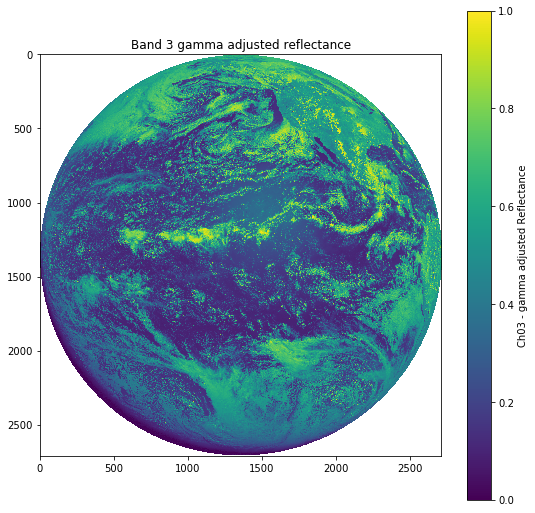

In [25]:
# Plot reflectance
image_name= "Band 3 gamma adjusted reflectance " + file_name + ".png"
fig = plt.figure(figsize=(9,9))
im = plt.imshow(ref_gamma_3)
plt.title('Band 3 gamma adjusted reflectance')
cb = fig.colorbar(im, orientation='vertical')
cb.set_ticks([0, 0.2, 0.4, 0.6, 0.8, 1.0])
cb.set_label('Ch03 - gamma adjusted Reflectance')
plt.show()
# plt.savefig(image_name, dpi=300, facecolor='w', edgecolor='w')

In [26]:
# Rebin function from https://stackoverflow.com/questions/8090229/resize-with-averaging-or-rebin-a-numpy-2d-array
def rebin(a, shape):
    sh = shape[0],a.shape[0]//shape[0],shape[1],a.shape[1]//shape[1]
    return a.reshape(sh).mean(-1).mean(1)

In [27]:
ref_gamma_2 = rebin(ref_gamma, [ref_gamma_1.shape[0], ref_gamma_1.shape[1]])

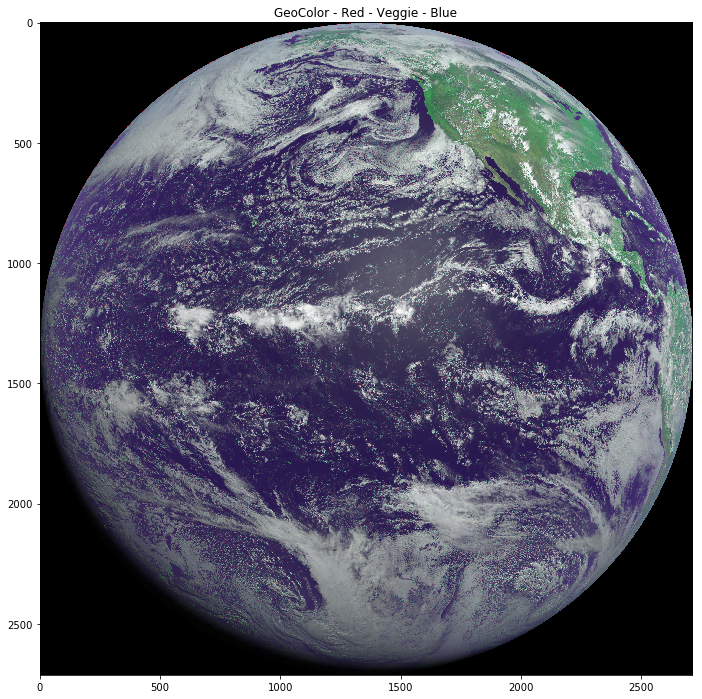

In [28]:
geocolor = np.stack([ref_gamma_2, ref_gamma_3, ref_gamma_1], axis=2)
fig = plt.figure(figsize=(12,12))
im = plt.imshow(geocolor)
plt.title('GeoColor - Red - Veggie - Blue')
plt.show()
image_name= "Geocolour image Red-Veggie-Blue " + file_name + ".png"
# plt.savefig(image_name, dpi=300, facecolor='w', edgecolor='w')

In [29]:
# Derived from Planet Labs data, CC > 0.9
ref_gamma_true_green = 0.48358168 * ref_gamma_2 + 0.45706946 * ref_gamma_1 + 0.06038137 * ref_gamma_3

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


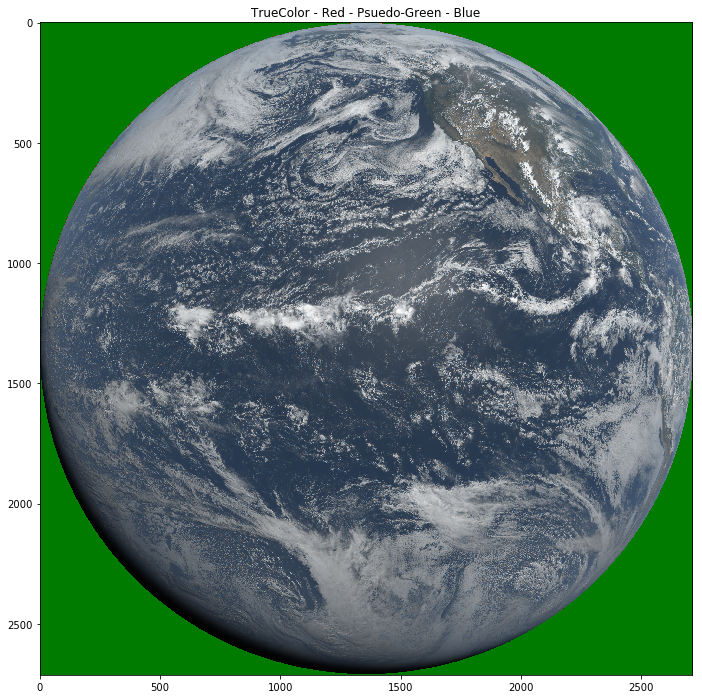

In [34]:
truecolor = np.stack([ref_gamma_2, ref_gamma_true_green, ref_gamma_1], axis=2)
fig = plt.figure(figsize=(12,12))
im = plt.imshow(truecolor)
plt.title('TrueColor - Red - Psuedo-Green - Blue')
plt.show()
image_name= "Truecolour image RGB " + file_name + ".png"
# plt.savefig(image_name, dpi=300, facecolor='w', edgecolor='w')